# CanESM5 GMD paper Figure 25&26 
## tas trends

### history
-  SJH, first look 2019-04-18

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
from pprint import pprint
import matplotlib.path as mpath
import os
from datetime import datetime
from cdo import Cdo
from scipy.stats import norm
import cmocean
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

In [46]:
%store -r tr_start 
%store -r tr_end
%store -r color_dict
%store -r label_fontsize
%store -r legend_fontsize

ts_start  = '1850-01-01'
ts_end    = '2019-01-01'
ts_startdate = datetime.strptime(ts_start,'%Y-%m-%d')
ts_enddate   = datetime.strptime(ts_end,'%Y-%m-%d')

refperiod_start = '1951-01-01'
refperiod_end   = '1980-01-01'
refperiod_startdate = datetime.strptime(refperiod_start,'%Y-%m-%d')
refperiod_enddate   = datetime.strptime(refperiod_end,'%Y-%m-%d')

his_start = tr_start
his_end = tr_end
his_startdate = datetime.strptime(his_start,'%Y-%m-%d')
his_enddate   = datetime.strptime(his_end,'%Y-%m-%d')

zm_start  = tr_start
zm_end    = tr_end
zm_startdate = datetime.strptime(zm_start,'%Y-%m-%d')
zm_enddate   = datetime.strptime(zm_end,'%Y-%m-%d')

obs_dir1    = 'input_data/obs_dir1'
CanESM5_dir = 'input_data/CanESM5_cmip_dir/historical/'
CanESM2_dir = 'input_data/CanESM2_combined_ensemble/tas/'


In [47]:
#using cdo for fieldmeans, since it can compute the area weighting more easily than with xarray
#typically only need to do this once

runCDO = False
     
if runCDO:

    #CanESM5
    for root, subdirs, files in os.walk(CanESM5_dir):
        for filename in files:
            var, tab, model, expt, rl, grid, dates = filename.split('_')
            if tab == 'Amon' and var == 'tas': 
                ifile = os.path.join(root,filename)
                ofile = 'input_data/processed_data/tas/fldmean_' + model + '-' + rl + '_'  + filename
                cdo.fldmean(input=ifile, output=ofile)
               
    #CanESM2      
    for root, subdirs, files in os.walk(CanESM2_dir):
        for filename in files:
            if filename.startswith('tas_Amon_CanESM2_historical_'): 
                var, tab, model, expt, rl, dates = filename.split('_')
                ifile = os.path.join(root,filename)
                ofile = 'input_data/processed_data/tas/fldmean_' + model + '-' + rl + '_'  + filename
                cdo.fldmean(input=ifile, output=ofile)  
           

    #obs files            
    for root, subdirs, files in os.walk(obs_dir1):
        for file in files:
            if file.startswith('tas'):
                obs_name = os.path.basename(os.path.normpath(root))
                ifile = os.path.join(root,file)
                ofile = 'processed_data/tas/fldmean_' + obs_name + '_'  + file
                cdo.fldmean(input=ifile, output=ofile)
                
    ifile = 'input_data/obs/HadCRUT/HadCRUT.4.6.0.0.median.nc'
    ofile = 'input_data/processed_data/tas/fldmean_HadCRUT4_HadCRUT.4.6.0.0.median.nc'
    cdo.fldmean(input=ifile, output=ofile)
    
    ifile = 'input_data/obs/NASA-GISS/gistemp1200_GHCNv4_ERSSTv5.nc'
    ofile = 'input_data/processed_data/tas/fldmean_NASA-GISS_gistemp1200_GHCNv4_ERSSTv5.nc'
    cdo.fldmean(input=ifile, output=ofile)
    
    ifile = 'input_data/obs/Berkeley-Earth/Land_and_Ocean_LatLong1.nc'
    ofile = 'input_data/processed_data/tas/fldmean_Berkeley-Earth_Land_and_Ocean_LatLong1.nc'
    cdo.fldmean(input=ifile, output=ofile)  

In [48]:
#Timeseries and histogram of trends for the global mean

#make dictionaries with data for each model/obs 

CanESM5 = {}
CanESM2 = {}
obs     = {}
for filename in os.listdir('input_data/processed_data/tas/'):
    if filename.startswith(('fldmean_CanESM5','fldmean_CanESM2')): 
        dataset_name = filename.split('_')[1]
        
        #global mean temps (absolute values)
        ds = xr.open_dataset(os.path.join('input_data/processed_data/tas/',filename))['tas']
        
        #annual global mean temp anomalies
        ann_means = pltm.get_month_weighted_annual_means(ds,'noleap', ts_start, ts_end)
        zero_val = ann_means.sel(year=slice(refperiod_start,refperiod_end)).mean()
        ann_mean_tempanomaly = (ann_means-zero_val).squeeze(dim=['lat', 'lon'])   
        if dataset_name.startswith('CanESM2-r'):
            ann_mean_tempanomaly = ann_mean_tempanomaly.sel(year=slice(ts_start,'1950-01-01')) #only use small ensemble data pre-1950 to avoid duplicate realizations (r1i1p1 == d1r1i1p1 extended backward)
    
        #global mean temp trends over specific period
        if dataset_name.startswith('CanESM2-r'):
            ann_means = ann_means.sel(year=slice(ts_start,'1950-01-01'))
        ann_means_his = ann_means.sel(year=slice(his_start,his_end)).squeeze(dim=['lat', 'lon'])
        cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means_his.year, ann_means_his))

        #make dict
        if dataset_name.startswith('CanESM5'):
            CanESM5[dataset_name] = {'ds':ds,'temp_anomaly':ann_mean_tempanomaly,'global_mean_trend':slope}
        if dataset_name.startswith('CanESM2'):
            CanESM2[dataset_name] = {'ds':ds,'temp_anomaly':ann_mean_tempanomaly,'global_mean_trend':slope}
        
        
    if filename.startswith(('fldmean_HadCRUT4','fldmean_NASA-GISS','fldmean_Berkeley-Earth_Land_and_Ocean_LatLong1')): 
        dataset_name = filename.split('_')[1]
        print(dataset_name)
        print('\n')
        
        #global mean temps (absolute values)
        ds = xr.open_dataset(os.path.join('input_data/processed_data/tas/',filename))
        ds = pltm.renameCoords(ds)
        #in NASA-GISS the time bounds variable, and the field status variable in HadCRUT wreaks havoc with the weighting
        if 'time_bnds' in ds.data_vars:
            ds = ds.drop('time_bnds', dim=None)
        #annual global mean temp anomalies and global mean temp trends over specific period   
        ann_means = pltm.get_month_weighted_annual_means(ds.squeeze(dim=['lat', 'lon']),'standard',ts_start,ts_end)
        zero_val = ann_means.sel(year=slice(refperiod_start,refperiod_end)).mean()
        ann_mean_tempanomaly = (ann_means-zero_val)
        ann_means_his = pltm.get_month_weighted_annual_means(ds.squeeze(dim=['lat', 'lon']),'standard',his_start,his_end)
        for key, value in ann_mean_tempanomaly.data_vars.items():
            if ('temp' in key.lower()):
                #global mean temp anomalies
                ann_mean_tempanomaly = ann_mean_tempanomaly.rename({key: 'temp_anomaly'})  
                #global mean temp trends over specific period
                ann_means_his = ann_means_his.rename({key: 'temp_anomaly'})
                cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means_his.year, ann_means_his.temp_anomaly))
                #make dict
                obs[dataset_name] = {'ds':ds,'temp_anomaly':ann_mean_tempanomaly,'global_mean_trend':slope}

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132:

Berkeley-Earth


HadCRUT4


NASA-GISS




/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132:

In [49]:
#get realization means 
CanESM5_rels = xr.concat([CanESM5[rel]['temp_anomaly'] for rel in CanESM5],dim='realization')
CanESM5_relmean = CanESM5_rels.mean('realization')

CanESM2_rels = xr.concat([CanESM2[rel]['temp_anomaly'] for rel in CanESM2],dim='realization')
CanESM2_relmean = CanESM2_rels.mean('realization')

In [50]:
#assemble data for histograms
CanESM5_hist = []
for realization in CanESM5:
    CanESM5_hist.append(CanESM5[realization]['global_mean_trend'])
    
CanESM2_hist = []
for realization in CanESM2:
    CanESM2_hist.append(CanESM2[realization]['global_mean_trend'])
    
#normal dist fits
x_vals = np.linspace(0.025, 0.055, 100)

CanESM5_hist = np.array(CanESM5_hist)
mu, sig = norm.fit(CanESM5_hist)
CanESM5_hist_fit_vals = norm.pdf(x_vals, mu, sig)    

CanESM2_hist = np.array(CanESM2_hist)
mu, sig = norm.fit(CanESM2_hist[np.isfinite(CanESM2_hist)])
CanESM2_hist_fit_vals = norm.pdf(x_vals, mu, sig)    

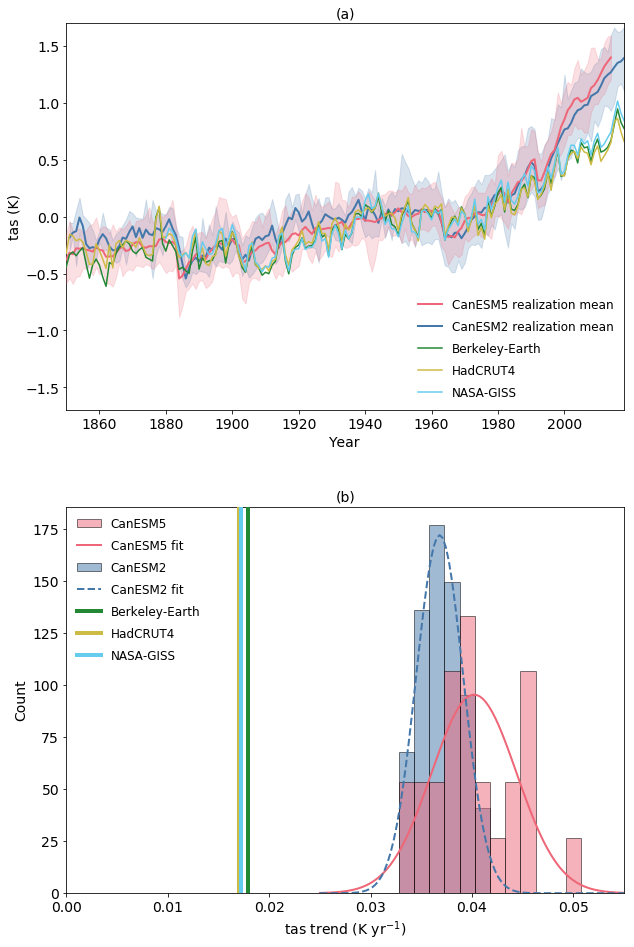

In [54]:
fig = plt.figure(figsize=(10,16))
          
ax1 = plt.subplot(2,1,1)
ax1.plot(CanESM5_relmean.year, CanESM5_relmean, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=30)
ax1.plot(CanESM2_relmean.year, CanESM2_relmean, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=20)
ax1.fill_between(CanESM5_rels.year, CanESM5_rels.min(dim='realization'), CanESM5_rels.max(dim='realization'), color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax1.fill_between(CanESM2_rels.year, CanESM2_rels.min(dim='realization'), CanESM2_rels.max(dim='realization'), color=color_dict['CanESM2'], alpha=0.2, zorder=0)
#for data_set in CanESM5:
#   ax1.plot(CanESM5[data_set]['temp_anomaly'].year, CanESM5[data_set]['temp_anomaly'],label='_nolegend_',color=color_dict['CanESM5'], alpha=0.1, zorder=1)
for data_set in obs:
    ax1.plot(obs[data_set]['temp_anomaly'].year, obs[data_set]['temp_anomaly'].temp_anomaly, label=data_set,color=color_dict[data_set], zorder=50)
ax1.set_xlim(ts_startdate.year, 2018)
ax1.set_ylim(-1.7, 1.7)
ax1.set_xlabel('Year')    
ax1.set_ylabel('tas (K)', fontsize=label_fontsize)    
ax1.legend(loc='lower right', ncol=1, labelspacing=0.75, fontsize=legend_fontsize, frameon=False )
ax1.set_title('(a)')

ax2 = plt.subplot(2,1,2)
data_bins=np.arange(min(CanESM5_hist), max(CanESM5_hist)+0.002, 0.0015) 
n, bins, patches = ax2.hist(CanESM5_hist,bins=data_bins, density=True, facecolor=color_dict['CanESM5'], edgecolor='k', alpha=0.5, label='CanESM5',zorder=10)
ax2.plot(x_vals, CanESM5_hist_fit_vals, color=color_dict['CanESM5'], linewidth=2,zorder=10,label='CanESM5 fit')
n, bins, patches = ax2.hist(CanESM2_hist,bins=data_bins, density=True, facecolor=color_dict['CanESM2'], edgecolor='k', alpha=0.5, label='CanESM2',zorder=0)
ax2.plot(x_vals, CanESM2_hist_fit_vals, color=color_dict['CanESM2'], linestyle='--', linewidth=2,zorder=10,label='CanESM2 fit')
for data_set in obs:
    ax2.axvline(obs[data_set]['global_mean_trend'], label=data_set, linewidth=4,color=color_dict[data_set],zorder=20)
ax2.set_xlabel('tas trend (K yr$^{-1}$)')    
ax2.set_ylabel('Count')    
handles, labels = ax2.get_legend_handles_labels()
ax2.legend([handles[5],handles[0],handles[6],handles[1],handles[2],handles[3],handles[4]], [labels[5],labels[0],labels[6],labels[1],labels[2],labels[3],labels[4]],loc='upper left', ncol=1, labelspacing=0.75, fontsize=legend_fontsize, frameon=False )
ax2.set_xlim(0.0, 0.055)
ax2.set_title('(b)')# Global mean trends in tas ('+str(his_startdate.year)+'-'+str(his_enddate.year)+')')

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(label_fontsize)
        
        
plt.subplots_adjust(hspace=0.25)  

plt.savefig('plots/fig-25_tas_timeseries_histogram.png', bbox_inches='tight')
plt.savefig('plots/fig-25_tas_timeseries_histogram.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for timeseries
xyzt = 'FFFT'
av_dims = ['time','lat','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections,time lat and lon for timeseries)
weight  = None
calc_skill_score = False
start = ts_start
end = '2014-01-01'

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM5','CanESM2','CanESM2','CanESM2']
model_datasets    = [CanESM5_relmean.sel(year=slice('1850','2014')),
                     CanESM5_relmean.sel(year=slice('1850','2014')),
                     CanESM5_relmean.sel(year=slice('1880','2014')),
                     CanESM2_relmean.sel(year=slice('1851','2014')),
                     CanESM2_relmean.sel(year=slice('1851','2014')),
                     CanESM2_relmean.sel(year=slice('1880','2014'))]
model_fulldatasets= [None,None,None,None,None,None]

obs_names     = ['Berkeley-Earth','HadCRUT4','NASA-GISS','Berkeley-Earth','HadCRUT4','NASA-GISS']
obs_datasets     = [obs['Berkeley-Earth']['temp_anomaly']['temp_anomaly'].sel(year=slice('1850','2014')), 
                    obs['HadCRUT4']['temp_anomaly']['temp_anomaly'].sel(year=slice('1850','2014')),
                    obs['NASA-GISS']['temp_anomaly']['temp_anomaly'].sel(year=slice('1880','2014')),
                    obs['Berkeley-Earth']['temp_anomaly']['temp_anomaly'].sel(year=slice('1851','2014')), 
                    obs['HadCRUT4']['temp_anomaly']['temp_anomaly'].sel(year=slice('1851','2014')),
                    obs['NASA-GISS']['temp_anomaly']['temp_anomaly'].sel(year=slice('1880','2014'))]
obs_fulldatasets = [None,None,None,None,None,None]

stats_names = ['tas_global_timeseries_v_Berkeley-Earth','tas_global_timeseries_v_HadCRUT4','tas_global_timeseries_v_NASA-GISS',
               'tas_global_timeseries_v_Berkeley-Earth_CanESM2','tas_global_timeseries_v_HadCRUT4_CanESM2','tas_global_timeseries_v_NASA-GISS_CanESM2']
varslist = ['tas','tas','tas','tas','tas','tas']         


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

In [34]:
#zonal mean of trends 

#make dictionaries with data for each model/obs 

CanESM5zm = {}
CanESM2zm = {}
obszm     = {}
i=0
#CanESM5      
print('CanESM5')
for root, subdirs, files in os.walk(CanESM5_dir):
    #narrow down the walk
    if 'Amon' in subdirs:
        subdirs[:] = ['Amon']
    if 'tas' in subdirs:
        subdirs[:] = ['tas']
    for filename in files:
        var, tab, model, expt, rl, grid, dates = filename.split('_')
        ds = xr.open_dataset(os.path.join(root,filename))['tas']
        ann_means = pltm.get_month_weighted_annual_means(ds, 'noleap', zm_start, zm_end)
        cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
        trends_zm = slope.mean(dim='lon')   
        CanESM5zm[rl] = {'ds':ds,'zm_trends':trends_zm,'global_trend':slope}
            
#CanESM2  
print('CanESM2')
for root, subdirs, files in os.walk(CanESM2_dir):
    for filename in files:
        if filename.startswith('tas_Amon_CanESM2_historical_d'): 
            var, tab, model, expt, rl, dates = filename.split('_')
            ds = xr.open_dataset(os.path.join(root,filename))['tas']
            ann_means = pltm.get_month_weighted_annual_means(ds, 'noleap', zm_start, zm_end)
            cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
            trends_zm = slope.mean(dim='lon')   
            CanESM2zm[rl] = {'ds':ds,'zm_trends':trends_zm,'global_trend':slope}
            
            
#obs
for file in ['input_data/obs/HadCRUT4/HadCRUT.4.6.0.0.median.nc','input_data/obs/NASA-GISS/gistemp1200_GHCNv4_ERSSTv5.nc','input_data/obs/Berkeley-Earth/Land_and_Ocean_LatLong1.nc']:
    obs_name = os.path.basename(os.path.dirname(file))
    print(obs_name)
    ds = xr.open_dataset(file)
    ds = pltm.renameCoords(ds)
    #in NASA-GISS the time bounds variable wreaks havoc with the weighting
    if 'time_bnds' in ds.data_vars:
            ds = ds.drop('time_bnds', dim=None)
    #in HADcrut the field status variable wreaks havoc with the weighting
    if 'field_status' in ds.data_vars:
        ds = ds.drop('field_status')
    ann_means = pltm.get_month_weighted_annual_means(ds, 'standard', zm_start, zm_end)
    for key, value in ann_means.data_vars.items():
        if ('temp' in key.lower()):
            ann_means = ann_means.rename({key: 'temp_anomaly'})
            cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means.temp_anomaly))
            trends_zm = slope.mean(dim='lon')   
            obszm[obs_name] = {'ds':ds,'zm_trends':trends_zm,'global_trend':slope}

CanESM5
CanESM2
HadCRUT4
renaming longitude
renaming latitude


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/s

NASA-GISS


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/s

Berkeley-Earth
renaming longitude
renaming latitude


In [35]:
#get realization means 
CanESM5zm_rels = xr.concat([CanESM5zm[rel]['zm_trends'] for rel in CanESM5zm],dim='realization')
CanESM5zm_mean = CanESM5zm_rels.mean('realization')
CanESM5global_trend_mean = xr.concat([CanESM5zm[rel]['global_trend'] for rel in CanESM5zm],dim='realization').mean('realization')

CanESM2zm_rels = xr.concat([CanESM2zm[rel]['zm_trends'] for rel in CanESM2zm],dim='realization')
CanESM2zm_mean = CanESM2zm_rels.mean('realization')


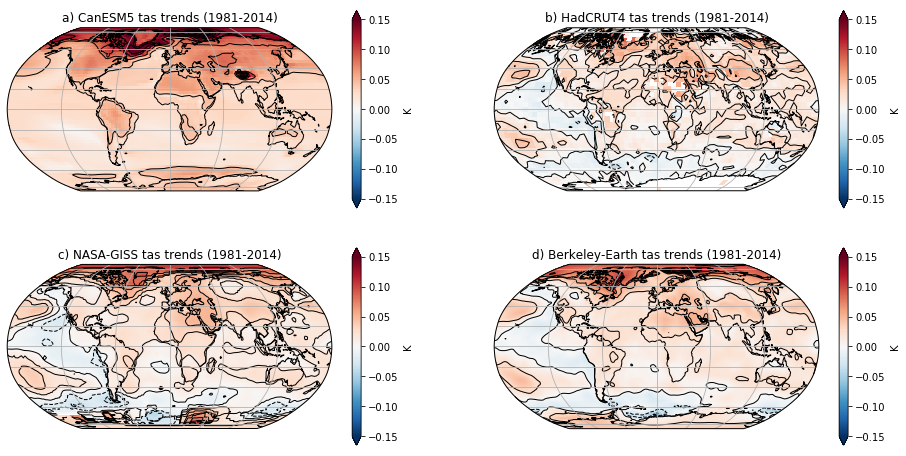

In [36]:
#trend map
fig = plt.figure(figsize=(16,8))

CanESM5_trend =  pltm.addCyclicPoint(CanESM5global_trend_mean, 'lon')
HC_trend = pltm.addCyclicPoint(obszm['HadCRUT4']['global_trend'], 'lon')
NG_trend = pltm.addCyclicPoint(obszm['NASA-GISS']['global_trend'], 'lon')
BE_trend = pltm.addCyclicPoint(obszm['Berkeley-Earth']['global_trend'], 'lon')

vmin = -0.15
vmax = 0.15 
cmap = plt.cm.RdBu_r

ax1 = plt.subplot(2,2,1,projection=ccrs.Robinson())  
im1 = ax1.pcolormesh(CanESM5_trend.lon,CanESM5_trend.lat,CanESM5_trend,vmin=vmin, vmax=vmax,cmap=cmap, transform=ccrs.PlateCarree())
ax1.contour(CanESM5_trend.lon, CanESM5_trend.lat, CanESM5_trend, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im1, ax=ax1, extend='both', label= 'K')
ax1.set_title('a) CanESM5 tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')


ax2 = plt.subplot(2,2,2,projection=ccrs.Robinson())  
im2 = ax2.pcolormesh(HC_trend.lon,HC_trend.lat,HC_trend,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
ax2.contour(HC_trend.lon, HC_trend.lat, HC_trend, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax2, extend='both', label= 'K')
ax2.set_title('b) HadCRUT4 tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')


ax3 = plt.subplot(2,2,3,projection=ccrs.Robinson())  
im3 = ax3.pcolormesh(NG_trend.lon,NG_trend.lat,NG_trend,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
ax3.contour(NG_trend.lon, NG_trend.lat, NG_trend, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax3, extend='both', label='K')
ax3.set_title('c) NASA-GISS tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')


ax4 = plt.subplot(2,2,4,projection=ccrs.Robinson())  
im4 = ax4.pcolormesh(BE_trend.lon,BE_trend.lat,BE_trend,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
ax4.contour(BE_trend.lon, BE_trend.lat, BE_trend, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax4, extend='both', label= 'K')
ax4.set_title('d) Berkeley-Earth tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')


for ax in [ax1,ax2,ax3,ax4]:
    ax.coastlines()
    ax.gridlines()

    
plt.savefig('plots/fig-X26_tas_trends_maps.png', bbox_inches='tight')

In [55]:
#trend map 2 - remapping for anomalies
CanESM5global_trend_mean_remap = xr.open_dataset('input_data/processed_data/remap-woa09_CanESM5global_mean_tas_trend_1981_2011.nc') #this is a remapped version of the realization mean created earlier 
CanESM5global_trend_mean_remap.rename(name_dict={'__xarray_dataarray_variable__':'temp_anomaly'}, inplace=True)
ds = xr.open_dataset('input_data/obs/HadCRUT4/remap-woa09_HadCRUT.4.6.0.0.median.nc')
ds = pltm.renameCoords(ds)
ann_means = pltm.get_month_weighted_annual_means(ds, 'standard', zm_start, zm_end)
for key, value in ann_means.data_vars.items():
    if ('temp' in key.lower()):
        ann_means = ann_means.rename({key: 'temp_anomaly'})
        cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means.temp_anomaly))
        HadCRUT4_trend_mean_remap = slope

trend_anom = CanESM5global_trend_mean_remap - HadCRUT4_trend_mean_remap


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


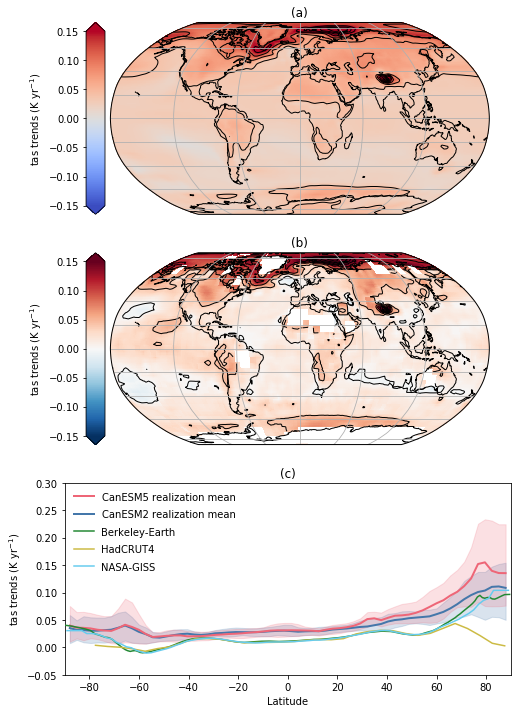

In [56]:
fig = plt.figure(figsize=(8,12))

vmin = -0.15
vmax = 0.15 
cmap = plt.cm.coolwarm

ax3 = plt.subplot(3,1,1,projection=ccrs.Robinson())  
im3 = ax3.pcolormesh(CanESM5global_trend_mean_remap.lon,CanESM5global_trend_mean_remap.lat,CanESM5global_trend_mean_remap.temp_anomaly,
                     vmin=vmin, vmax=vmax,cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True)
cn3 = ax3.contour(CanESM5global_trend_mean_remap.lon, CanESM5global_trend_mean_remap.lat, CanESM5global_trend_mean_remap.temp_anomaly, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
pltm.add_cbar('left', fig, ax3, im3, extend='both', label =r'tas trends (K yr$^{-1}$)')
ax3.set_title('(a)')# CanESM5 tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')

ax4 = plt.subplot(3,1,2,projection=ccrs.Robinson())  
im4 = ax4.pcolormesh(trend_anom.lon,trend_anom.lat,trend_anom.temp_anomaly,vmin=vmin, vmax=vmax,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree()
                    , rasterized=True)
cn4 = ax4.contour(trend_anom.lon, trend_anom.lat, trend_anom.temp_anomaly, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
pltm.add_cbar('left', fig, ax4, im4, extend='both', label =r'tas trends (K yr$^{-1}$)')
ax4.set_title('(b)')# CanESM5 - HadCRUT4 (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')


ax1 = plt.subplot(3,1,3)
ax1.plot(CanESM5zm_mean.lat, CanESM5zm_mean, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=30)
ax1.plot(CanESM2zm_mean.lat, CanESM2zm_mean, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=20)
ax1.fill_between(CanESM5zm_rels.lat, CanESM5zm_rels.min(dim='realization'), CanESM5zm_rels.max(dim='realization'), color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax1.fill_between(CanESM2zm_rels.lat, CanESM2zm_rels.min(dim='realization'), CanESM2zm_rels.max(dim='realization'), color=color_dict['CanESM2'], alpha=0.2, zorder=0)
#for data_set in CanESM5:
#    ax1.plot(CanESM5zm[data_set]['zm_trends'].lat, CanESM5zm[data_set]['zm_trends'],label='_nolegend_',color='lightgrey', zorder=0)
for data_set in obs:
    ax1.plot(obszm[data_set]['zm_trends'].lat, obszm[data_set]['zm_trends'], label=data_set,color=color_dict[data_set], zorder=50)
ax1.legend(loc='upper left', ncol=1, labelspacing=0.75,frameon=False )
ax1.set_xlim(-90, 90)
ax1.set_ylim(-0.05, 0.3)
ax1.set_xlabel('Latitude')    
ax1.set_ylabel('tas trends (K yr$^{-1}$)')    
ax1.set_title('(c)')#' Zonal mean trends in tas ('+str(zm_startdate.year)+'-'+str(zm_enddate.year)+')')


for ax in [ax3,ax4]:
    ax.coastlines()
    ax.gridlines()
    

plt.savefig('plots/fig-26_tas_trends_mapz_zm.png', bbox_inches='tight')
plt.savefig('plots/fig-26_tas_trends_mapz_zm.pdf', bbox_inches='tight')

In [39]:
#basic statistics - for zonal means
stat_type = 'zonal_timemean_trends'

#obs
obs = [obszm['Berkeley-Earth']['zm_trends'],obszm['HadCRUT4']['zm_trends'],obszm['NASA-GISS']['zm_trends']]
obs_name = ['Berkeley-Earth','HadCRUT4','NASA-GISS']


#CanESM5 - so far just using r1 here
models = [CanESM5zm_mean,CanESM5zm_mean,CanESM5zm_mean]
model_names = ['CanESM5','CanESM5','CanESM5']

#names
stats_names = ['tas_zonal_timemean_BE','tas_zonal_timemean_HadCRUT4','tas_zonal_timemean_NASA-GISS',]
         
#vars
varslist = ['tas','tas','tas']    
    
conn = sqlite3.connect('stats.db')
c = conn.cursor()       
for ob, ob_name, model, model_name, stats_name, var in zip(obs,obs_name,models,model_names,stats_names,varslist):
    stats = bst.get_stats(model, ob, weights=None)
    bst.write_stats_to_file(stats_name, stats, var=var, model=model_name, obs=ob_name, startdate=his_start, enddate=his_end, data_type=stat_type)
    
    statsline = (var, model_name, ob_name, his_start, his_end, stat_type, stats['bias'],stats['RMSE'],stats['corrcoeff'],stats['model_std'],stats['obs_std'])
    c.execute("insert into basic_stats(var, model, obs, startdate, enddate, data_type, bias, RMSE, corrcoeff, model_std, obs_std) values (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", statsline)   
    conn.commit()
    
conn.close()


AttributeError: module 'modules.basic_stats' has no attribute 'get_stats'

In [ ]:
fig = plt.figure(figsize=(16,6))

vmin = -0.15
vmax = 0.15 
cmap = plt.cm.coolwarm

# Compute a circle in axes coordinates, which we can use as a boundary (from cartopy example gallery)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1 = plt.subplot(1,2,1,projection=ccrs.NorthPolarStereo())  
im1 = ax1.pcolormesh(CanESM5global_trend_mean_remap.lon,CanESM5global_trend_mean_remap.lat,CanESM5global_trend_mean_remap.temp_anomaly,vmin=vmin, vmax=vmax,cmap=cmap, transform=ccrs.PlateCarree())
cn1 = ax1.contour(CanESM5global_trend_mean_remap.lon, CanESM5global_trend_mean_remap.lat, CanESM5global_trend_mean_remap.temp_anomaly, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im1, ax=ax1, extend='both', label= 'K')
ax1.set_title('(a)')#' CanESM5 tas trends (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')

ax2 = plt.subplot(1,2,2,projection=ccrs.NorthPolarStereo())  
im2 = ax2.pcolormesh(trend_anom.lon,trend_anom.lat,trend_anom.temp_anomaly,vmin=vmin, vmax=vmax,cmap=plt.cm.RdBu_r,transform=ccrs.PlateCarree())
cn2 = ax2.contour(trend_anom.lon, trend_anom.lat, trend_anom.temp_anomaly, 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax2, extend='both', label= 'K')
ax2.set_title('(b)')#' CanESM5 - HadCRUT4 (' + str(zm_startdate.year) + '-' +  str(zm_enddate.year)+')')

for ax,im,cn in zip([ax1,ax2],[im1,im2],[cn1,cn2]):
    for c in cn.collections:
        c.set_clip_path(circle, transform=ax.transAxes) 
    im.set_clip_path(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, 90, 45],ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.coastlines()
    ax.gridlines()

plt.savefig('plots/fig-X26_tas_trends_polarmaps.png', bbox_inches='tight')